In [52]:
# finetuning llama2

In [53]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1

In [54]:

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

full_lora_layers = [
    "embed_tokens",
    "lm_head",
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]


def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map="auto",
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map="auto",
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [55]:
#init model

model_size=7
r=32
lora_alpha=32
bit=16
target_modules= [
    "embed_tokens",
    "lm_head",
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]
target_modules=[]
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"


#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


Using fp16 mode


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


In [56]:

pipe = pipeline("text-generation", model=model,
                tokenizer=tokenizer, max_new_tokens=1000)

In [57]:
import pandas as pd
df=pd.read_csv("dataset/231225AutoReasoning/231228best_reason_record.csv")
dataset=df.to_dict(orient="records")
df[:2]

,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,(-)-2-amino-3-phenyl-1-propanol,NC(Cc1ccccc1)CO,69116,http://www.amazon.com/dp/B003XEQTLE,Aldrich Chemical Company; Aldrich Catalog-Hand...,The compound (-)-2-amino-3-phenyl-1-propanol h...,92.0,92.0,0.0
1,(3Z)-5-Isobutyl-3-[(5-phenyl-2-furyl)methylene...,O=C1OC(=CC1=Cc1oc(cc1)c1ccccc1)CC(C)C,1474618,http://dx.doi.org/10.1021/ci0500132,Karthikeyan M.; Glen R.C.; Bender A. General m...,To predict the melting point of (3Z)-5-Isobuty...,76.0,76.0,0.0


In [67]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction="",prefix="Example"):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#{prefix} Data
##Name: {name}
##SMILES: {smiles} 
##Reason: {reason}
##Prediction: {prediction}
"""
    return prompt




def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id],prefix="Test")
    prompt+="""
#Output: Reason, Prediction
    """

    return prompt

In [68]:

import re
def ask_value(prompt,pipe):
    res=pipe(prompt)[0]["generated_text"]
    res=res[len(prompt):]

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        #r"Prediction:\s*(\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break
    return res,value
    

In [69]:
import copy
prediction_results={}

n_problems=10
for n_prompt_examples in [1,5,10]:
    res_list=[]
    for test_id in range(n_problems):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,pipe)
            record=copy.deepcopy(dataset[test_id])

            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print(record)
        except Exception as e:
            print(e)
            continue

    prediction_results[n_prompt_examples]=res_list

{'name': '(-)-2-amino-3-phenyl-1-propanol', 'smiles': 'NC(Cc1ccccc1)CO', 'csid': 69116, 'link': 'http://www.amazon.com/dp/B003XEQTLE', 'source': 'Aldrich Chemical Company; Aldrich Catalog-Handbook of Fine Chemicals; Milwaukee; WI; 1984.', 'Reason': "The compound (-)-2-amino-3-phenyl-1-propanol has multiple functional groups that contribute to a higher melting point than the base molecule propane, which is a gas at room temperature. The amino group contributes approximately +50 degrees due to its ability to form intermolecular hydrogen bonds and to the increase in molecular weight. The hydroxyl group also contributes around +50 degrees because of its strong hydrogen bonding capability. The phenyl group is responsible for an increase of about +100 degrees due to the rigidity of the benzene ring and potential π-π interactions, providing a significant increase in melting point. However, since the amino and hydroxyl groups are present in the same molecule, they are capable of engaging in in

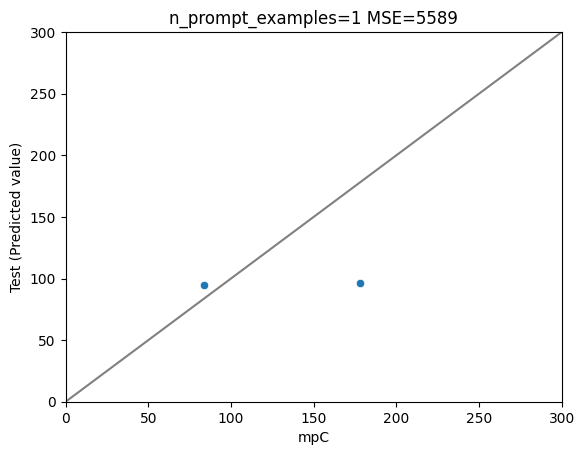

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

vmin=0
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    #break

In [66]:
print(prompt)


#Example Data
##Name: (1R,2s)-10,2-camphorsultam
##SMILES: CC1([C@H]2CC[C@@]13CS(=O)(=O)N[C@H]3C2)C 
##Reason: To predict the melting point of (1R,2s)-10,2-camphorsultam, we would examine its functional groups and structure. The base structure is the bicyclic ring system found in camphor, which by itself has a melting point of 176 to 178°C. The sultam group (a sulfonyl group bonded to an amine) is a strong polar, electron-withdrawing group, and it may increase melting point due to its potential for intermolecular hydrogen bonding and dipole-dipole interactions, adding approximately +10°C. The tertiary butyl group adds steric bulk, which can increase melting point, but because it is nonpolar, the effect is likely weaker in this context; we could estimate it contributes a +5°C increase due to its steric bulk affecting the crystal lattice stability. These effects combined would lead to a prediction slightly higher than the base structure of camphor.
##Prediction: 191.0


#Test Data
##Nam